# NMME Niño 3.4

In [1]:
import numpy as np
import xarray as xr

import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
nmme_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/'
n34_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

In [3]:
model_list = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']

## Functions

In [4]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [5]:
def ac_by_start(x, y):
    xa = x.groupby('S.month') - x.groupby('S.month').mean('S') 
    ya = y.groupby('S.month') - y.groupby('S.month').mean('S') 
    c = (xa*ya).groupby('S.month').mean('S')/xa.groupby('S.month').std('S')/ya.groupby('S.month').std('S')
    c.attrs['long_name'] = 'correlation'
    c.month.attrs['long_name'] = 'start month'
    return c

In [6]:
def msess_by_start(f, o):
    #assumes f and o are anomalies
    # the reference forecast is zero anomaly
    #use mean NOT sum to get the desired nan behavior (nan if all values missing)
    msess = 1.0 - ((f - o)**2).groupby('S.month').mean('S')/(o**2).groupby('S.month').mean('S')
    msess.attrs['long_name'] = 'MSESS'
    msess.month.attrs['long_name'] = 'start month'
    return msess

# Read data

## Obserations (ERSSTv5)

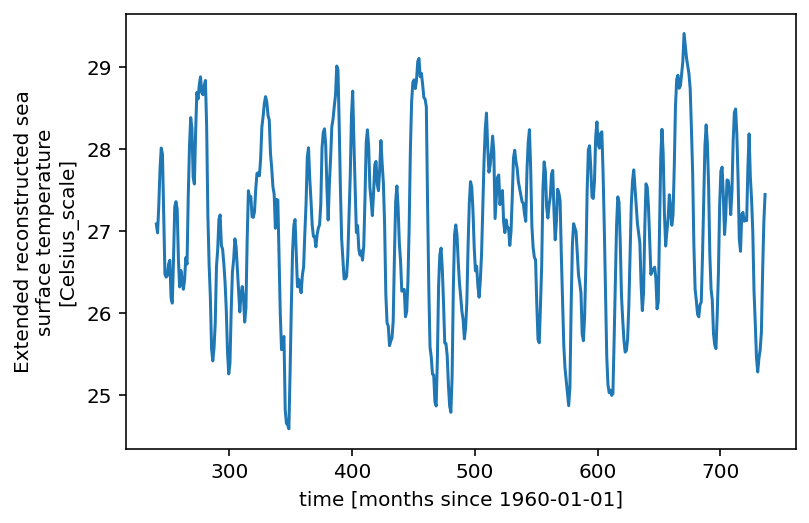

In [7]:
#Observations NOT subsetted to match
# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
time_str = 'T/(Jan%201980)/last/RANGE/'
obs_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + n34_url + 'zlev/removeGRID/' + 'dods'

obs_ds = xr.open_dataset(obs_url, decode_times=False)

# BECAUSE the forecasts go beyond the obs pad with 14 nan
extra_T = np.arange(obs_ds.T[0], obs_ds.T[-1] + 14)
obs_ds_padded = obs_ds.reindex({'T': extra_T})
obs = obs_ds_padded.sst
obs.plot();

# Six active NMME models

In [8]:
# We will make a list of data sets and then merge
ds_list = []

## 0. CanCM4i

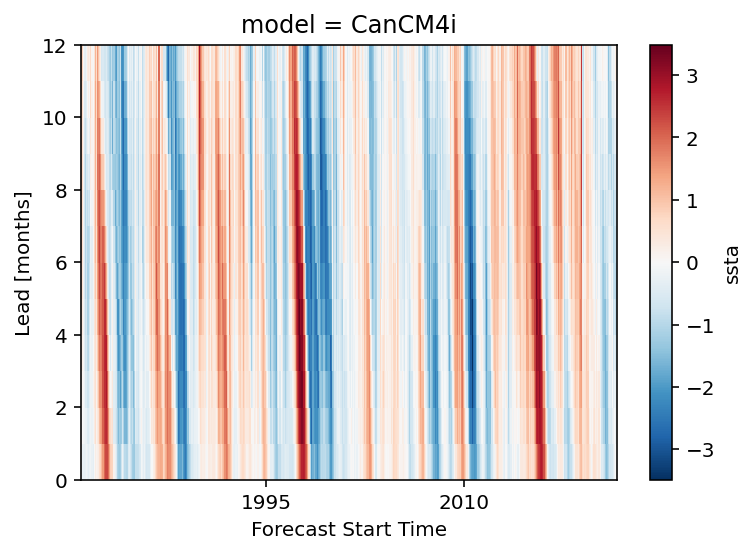

In [9]:
#CanCM4i
model = 'CanCM4i'
h_url = nmme_url + '.CanCM4i/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)

f_url = nmme_url + '.CanCM4i/.FORECAST/.MONTHLY/.sst/S/(Jan%202019)/last/RANGE/' + n34_url + 'dods'
f_ds = xr.open_dataset(f_url, decode_times=False)

ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15
T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')

f = ds.sst
ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [10]:
ds_list.append(ds)

## 1. GEM-NEMO

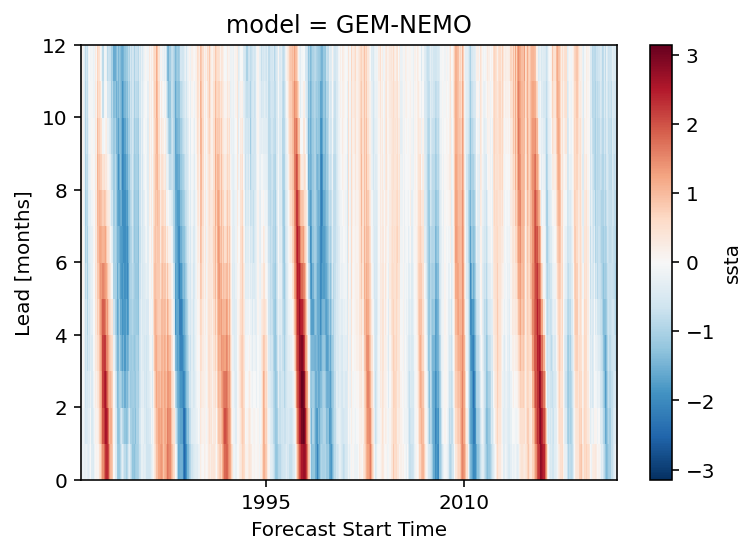

In [11]:
#GEM-NEMO
model = 'GEM-NEMO'
h_url = nmme_url + '.GEM-NEMO/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/S/(Jan%202019)/last/RANGE/' + n34_url +'dods'
#f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/' + n34_url +'dods'

h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')
f = ds.sst
ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [12]:
ds_list.append(ds)

## 2. GFDL-SPEAR

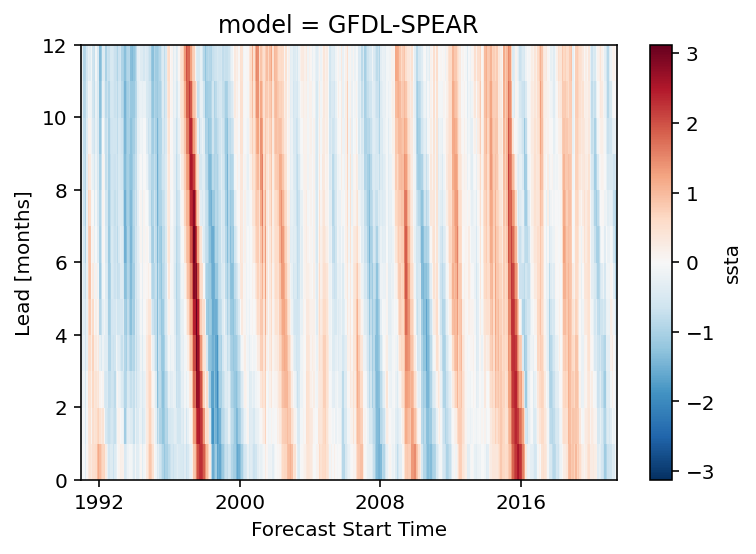

In [13]:
#GFDL-SPEAR
model = 'GFDL-SPEAR'
h_url = nmme_url + '.GFDL-SPEAR/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
f_url = nmme_url + '.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst/S/(Jan%202021)/last/RANGE/' + n34_url + 'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of lead in hindcast
# should make lead a function of start
ds['Lmax'] = len(h_ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')
f = ds.sst
ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [14]:
ds_list.append(ds)

## 3. COLA-RSMAS-CCSM4

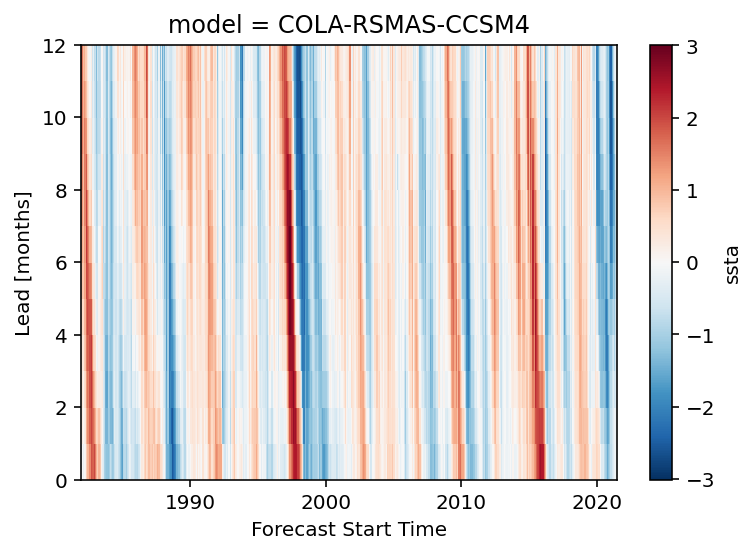

In [15]:
#COLA-RSMAS-CCSM4
model = 'COLA-RSMAS-CCSM4'
url = nmme_url + '.COLA-RSMAS-CCSM4/.MONTHLY/.sst/' + n34_url + 'dods'
ds = xr.open_dataset(url, decode_times=False)

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')

f1 = ds.sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))
f2 = ds.sst.sel(S=slice('1999-01-01', '2021-12-01'))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta = xr.concat([ssta1, ssta2], dim='S')

ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [16]:
ds_list.append(ds)

## 4. NASA-GEOSS2S

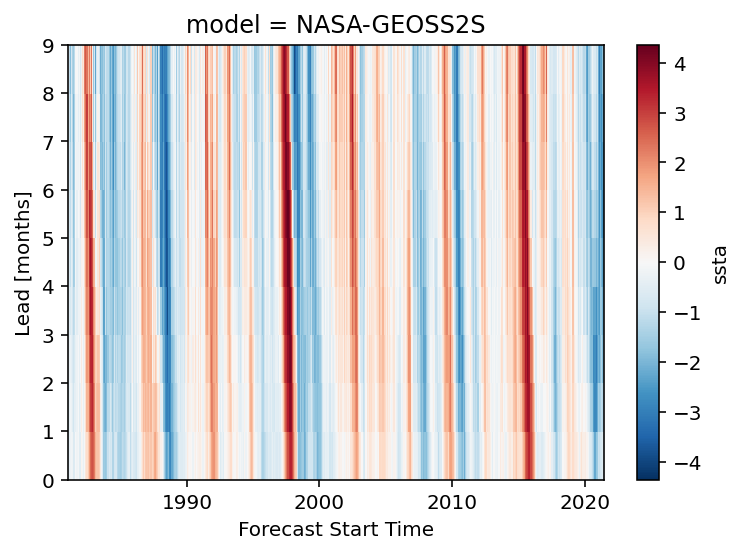

In [17]:
#NASA-GEOSS2S
model = 'NASA-GEOSS2S'

h_url = nmme_url + '.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NASA-GEOSS2S/.FORECAST/.MONTHLY/.sst/' + n34_url +'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of lead in hindcast
# should make lead a function of start
ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')
f = ds.sst
ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [18]:
ds_list.append(ds)

## 5. NCEP-CFSv2

CFSv

Compute anaomlies by removing 2 forecast climatologies. One for 1982-1998 and one for 1999-2020.

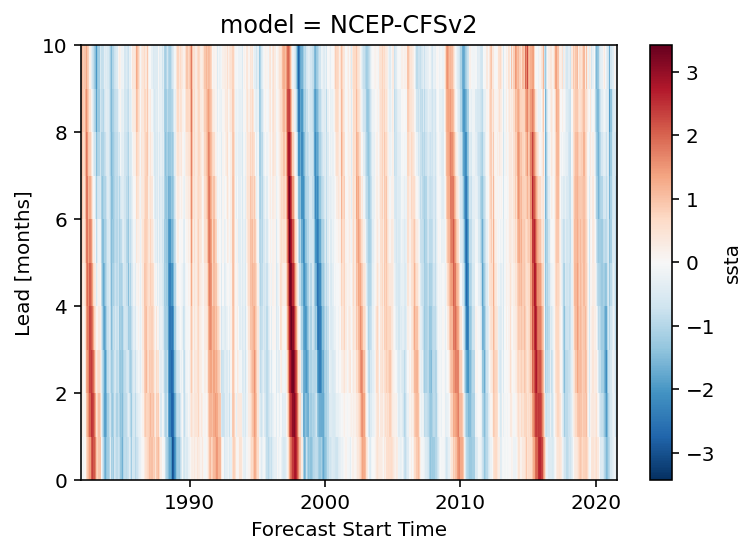

In [19]:
#NCEP-CFSv2
model = 'NCEP-CFSv2'
h_url = nmme_url + '.NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + n34_url +'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)
ds['Mmax'] = 24

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')

f1 = ds.sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))
f2 = ds.sst.sel(S=slice('1999-01-01', '2021-12-01'))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta = xr.concat([ssta1, ssta2], dim='S')

ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [20]:
ds_list.append(ds)

## Multimodel ensemble

In [21]:
ds = xr.merge(ds_list)

o = ds.obs
ds['obsa'] = o.groupby("S.month") - o.sel(S=slice('1991-01-01', '2020-12-01')).groupby("S.month").mean("S")
ds

<xarray.Dataset>
Dimensions:  (L: 12, M: 30, S: 487, model: 6)
Coordinates:
  * L        (L) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * M        (M) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 26.0 27.0 28.0 29.0 30.0
  * S        (S) object 1981-01-01 00:00:00 ... 2021-07-01 00:00:00
  * model    (model) <U16 'COLA-RSMAS-CCSM4' 'CanCM4i' ... 'NCEP-CFSv2'
    month    (S) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 ... 2.0 3.0 4.0 5.0 6.0 7.0
Data variables:
    sst      (model, S, M, L) float64 nan nan nan nan nan ... nan nan nan nan
    Lmax     (model) float64 12.0 12.0 12.0 12.0 9.0 10.0
    Mmax     (model) float64 10.0 10.0 10.0 15.0 4.0 24.0
    obs      (L, S) float64 26.19 26.12 26.66 27.3 27.36 ... nan nan nan nan nan
    ssta     (model, S, M, L) float64 nan nan nan nan nan ... nan nan nan nan
    obsa     (L, S) float64 -0.3642 -0.6403 -0.6359 -0.5294 ... nan nan nan nan
Attributes:
    Conventions:  IRIDL

# Save local copy (if you want, or skip)

In [22]:
ds_saved = ds.copy()

import pickle
#save a copy locally
with open('n34_nmme_saved_on_disk', 'wb') as f:
    pickle.dump(ds, f, pickle.HIGHEST_PROTOCOL)

In [23]:
#read a copy 
with open('n34_nmme_saved_on_disk', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ds = pickle.load(f)

# Plot data

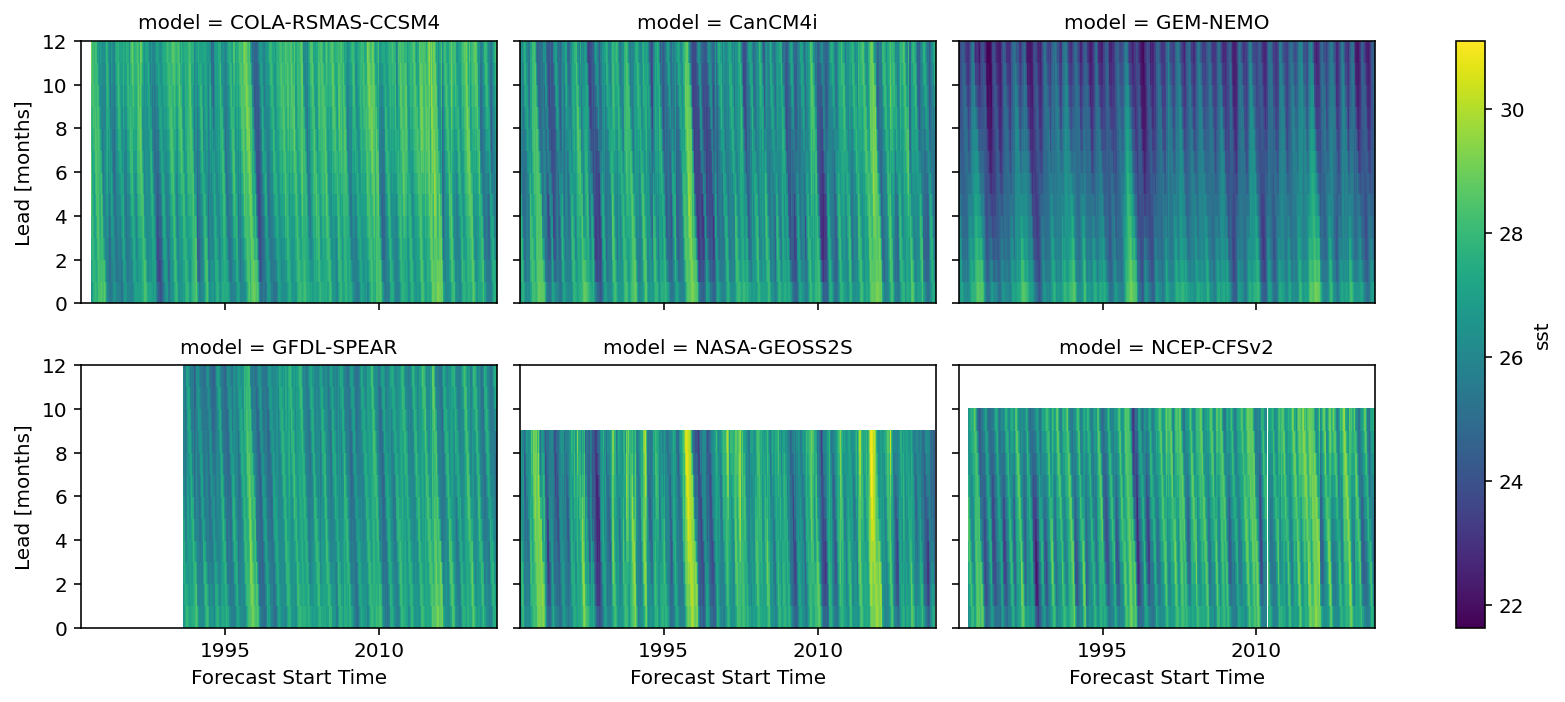

In [24]:
#Ensemble mean (total)
ds.sst.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

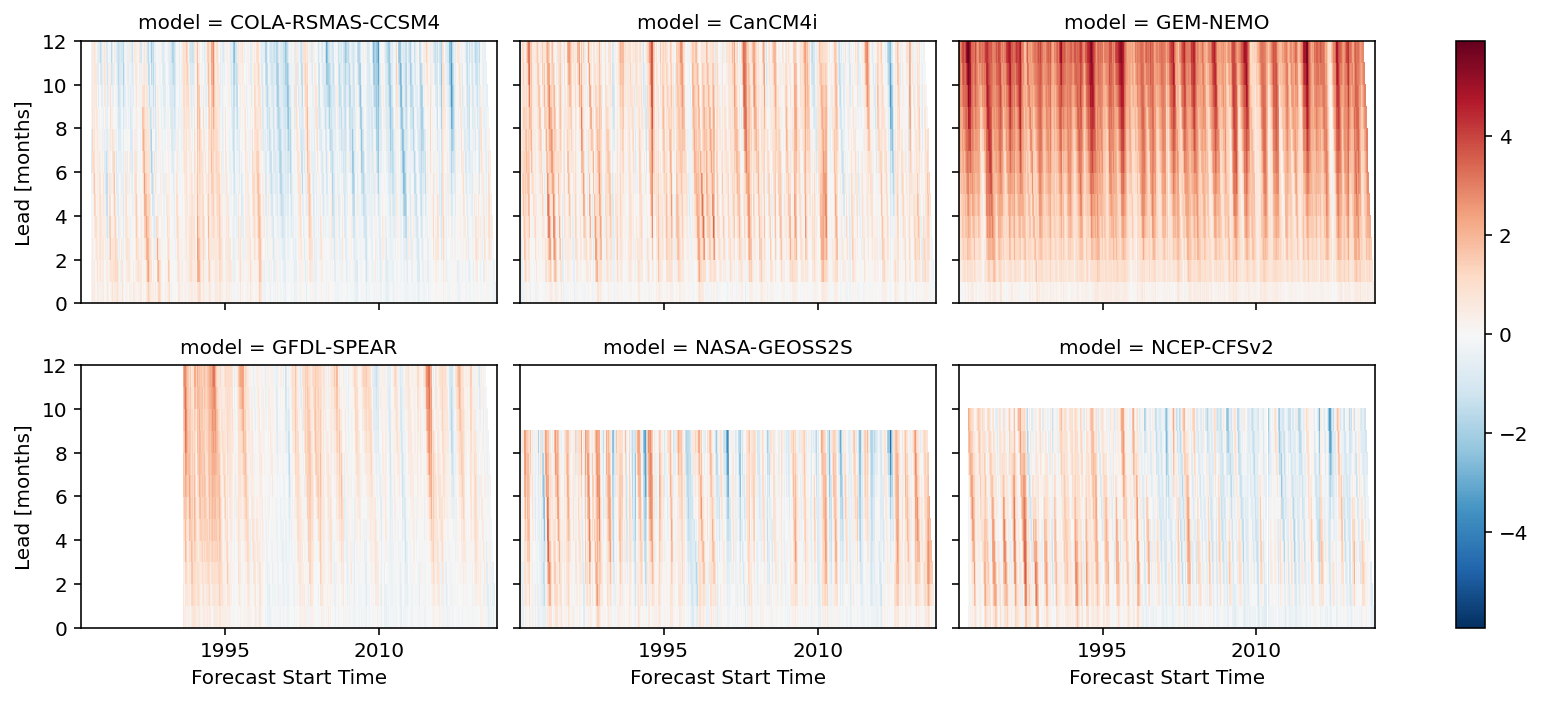

In [25]:
#Ensemble mean error (total)
(ds.obs - ds.sst.mean('M')).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

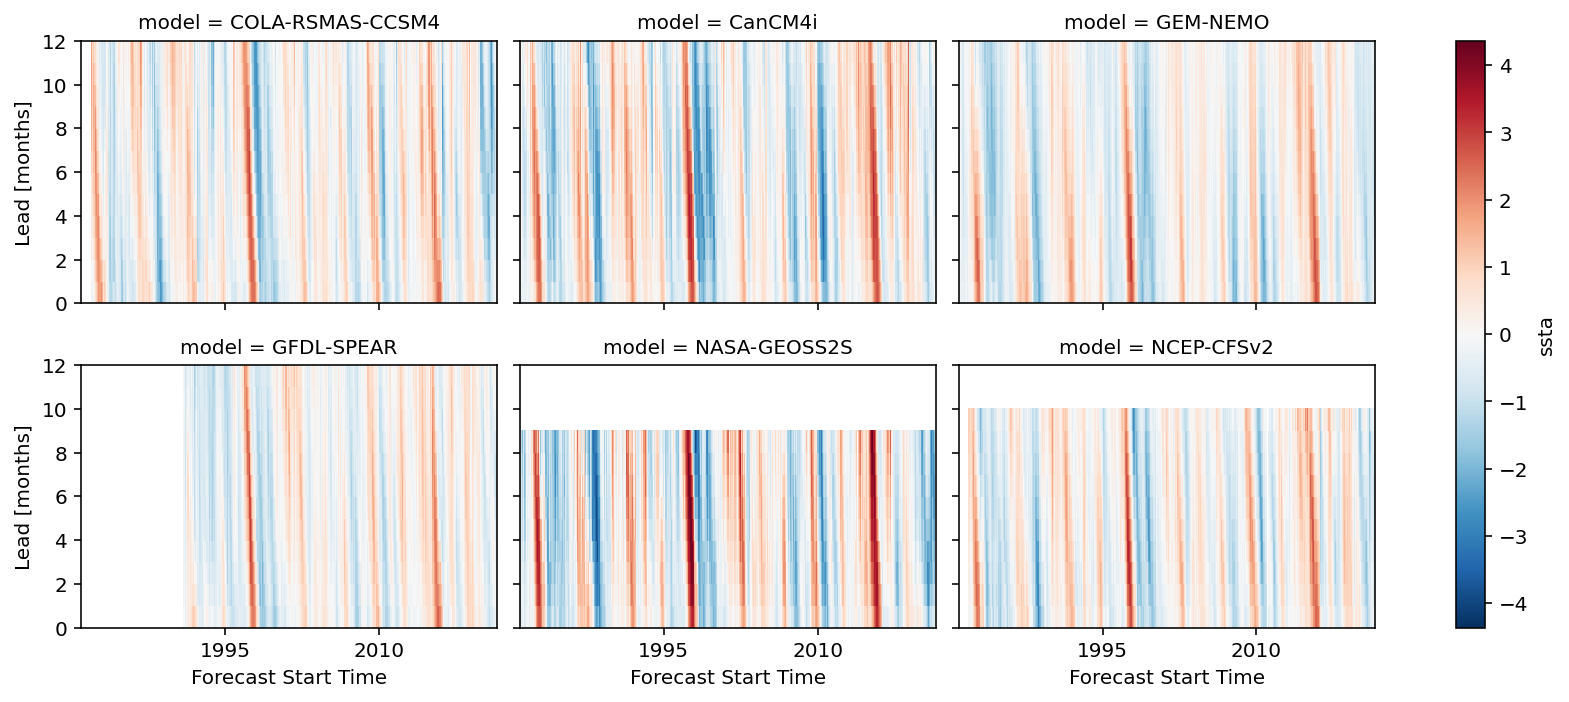

In [26]:
#Ensemble mean anomalies
ds.ssta.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

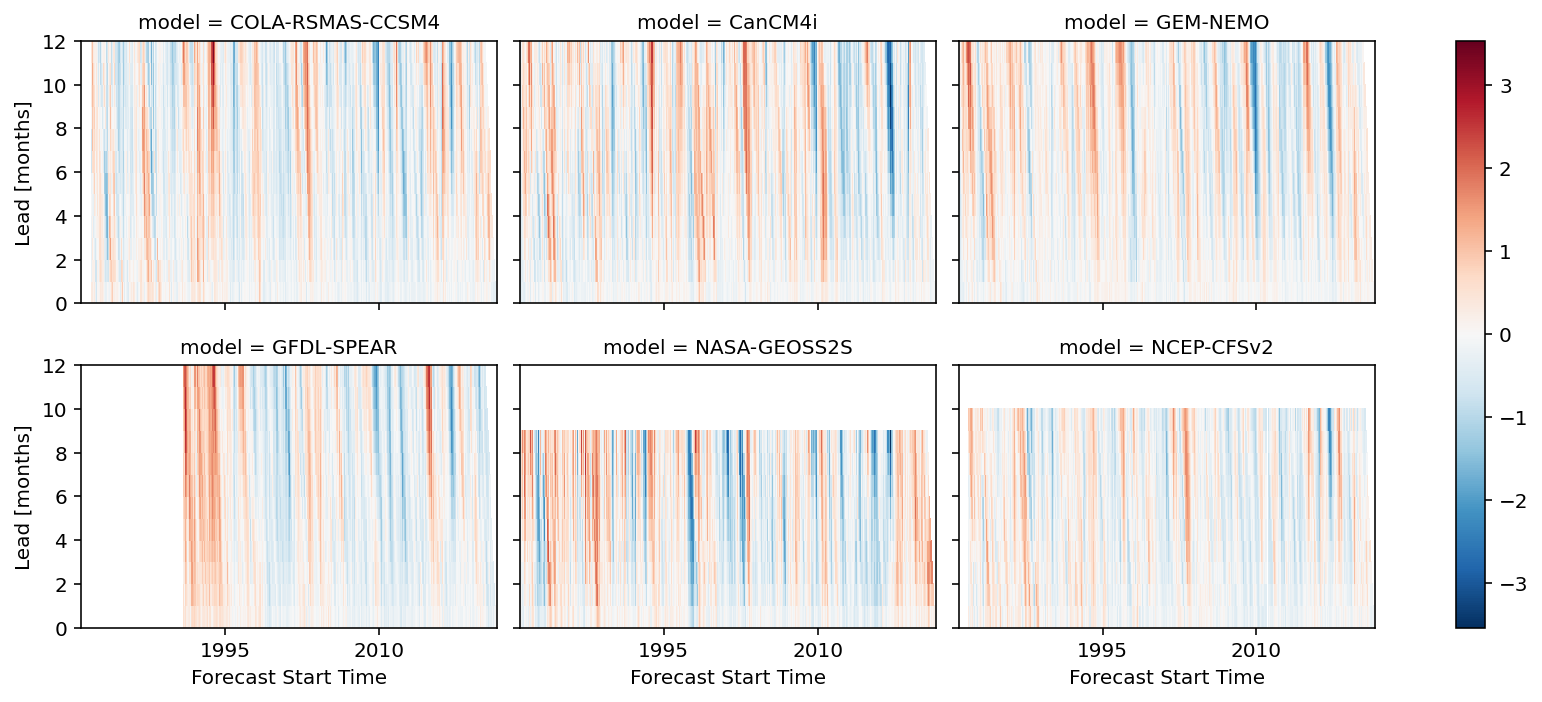

In [27]:
#Ensemble mean anomaly error
(ds.obsa - ds.ssta.mean('M')).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

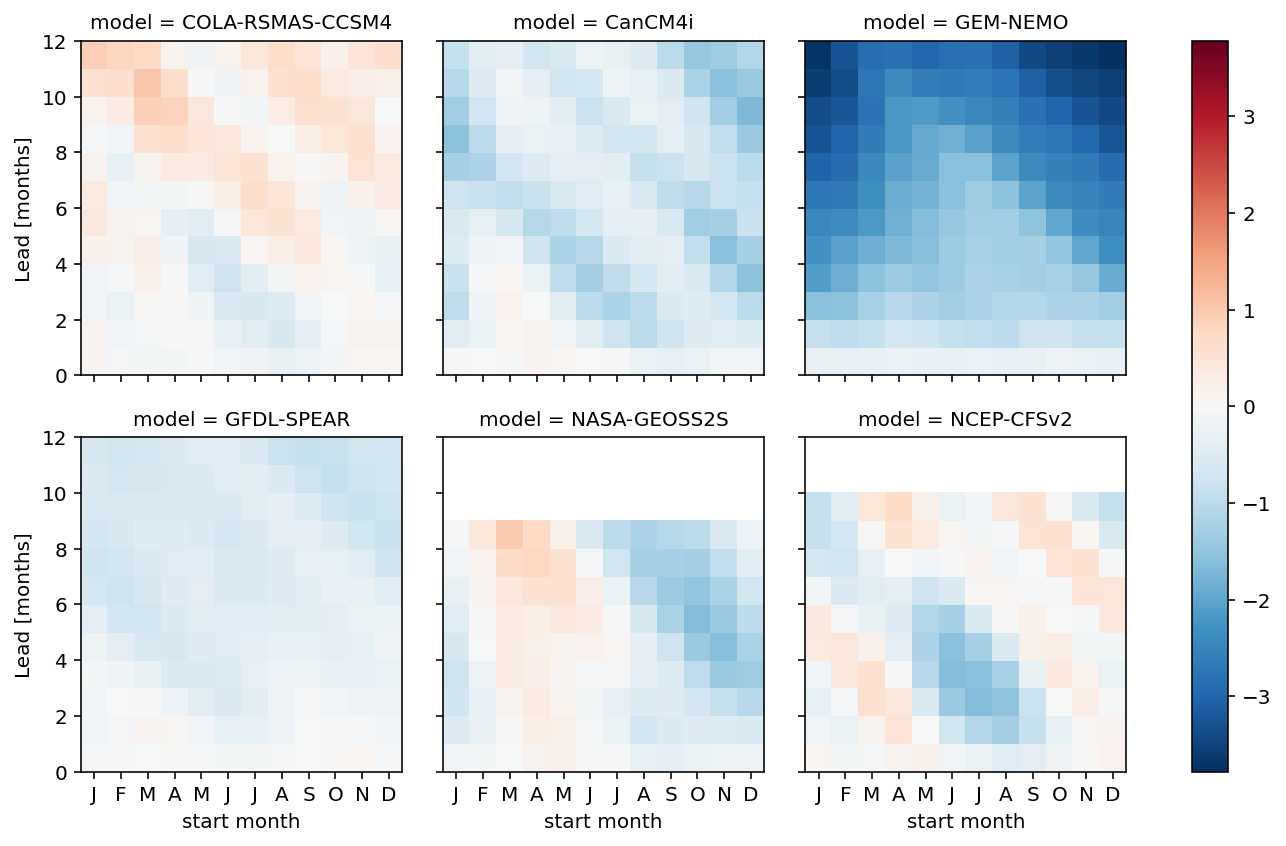

In [28]:
# Bias
bias = (ds.sst - ds.obs).groupby('S.month').mean(('M', 'S'))
bias.month.attrs['long_name'] = 'start month'
bias.plot(col='model', col_wrap = 3, x='month')
plt.xticks(ds.L + 0.5, labels=m_str)
plt.show()

# Skill by lead (not trajectories)

## 1. Correlation

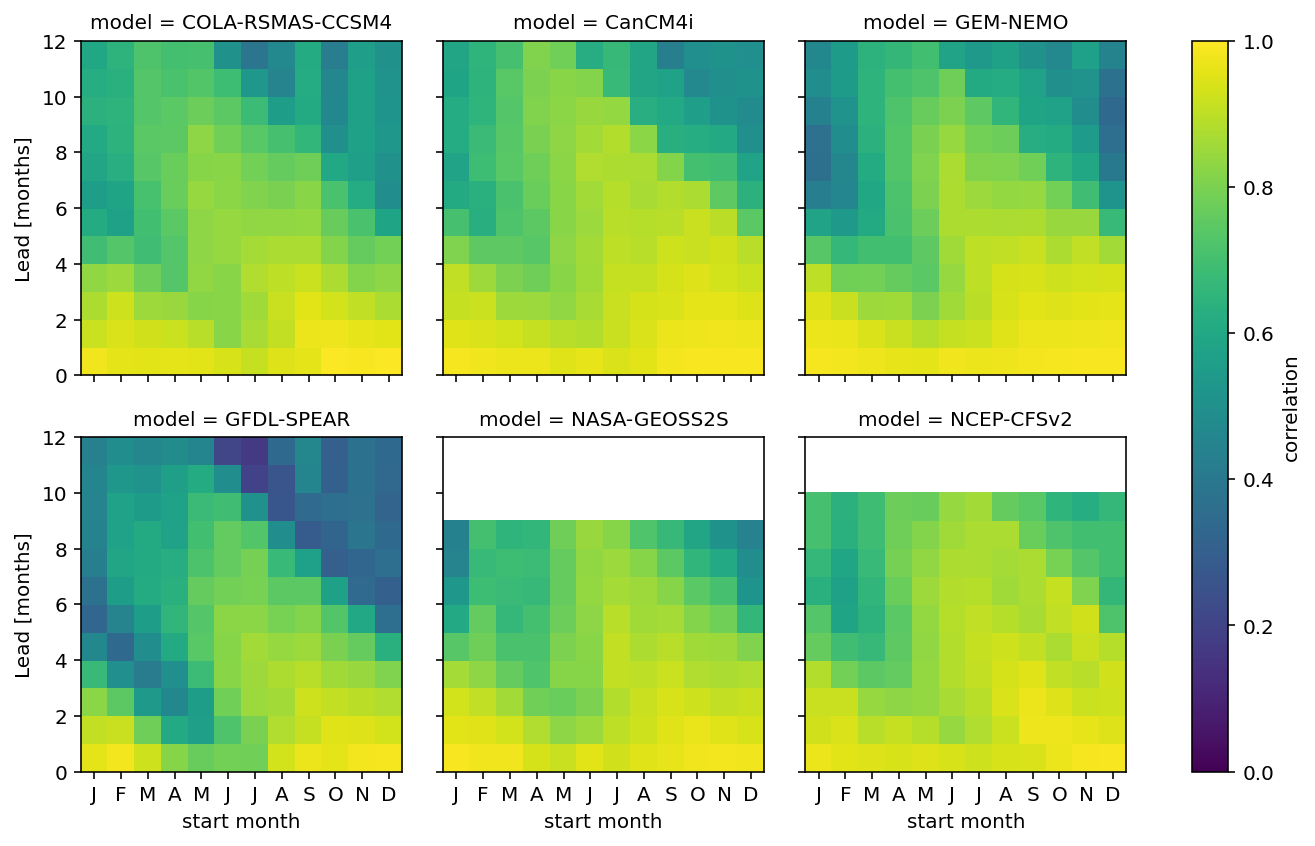

In [29]:
ac = ac_by_start(ds.ssta.mean('M'), ds.obsa)
ac.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.show()

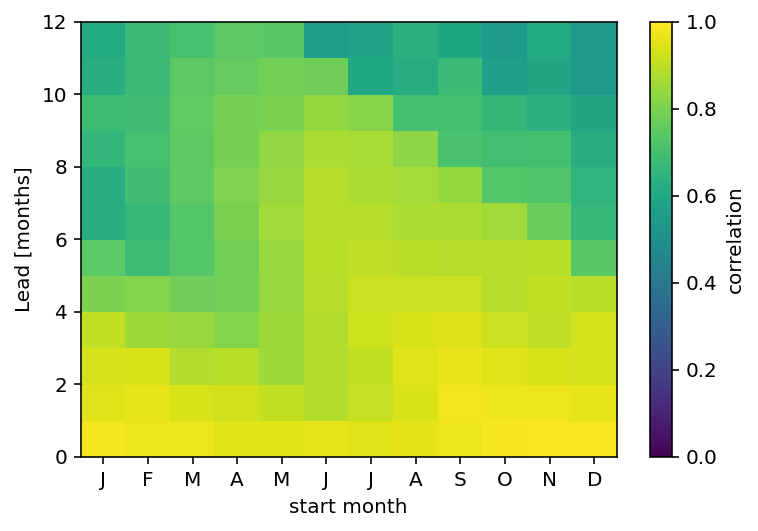

In [30]:
ac_mme = ac_by_start(ds.ssta.mean(('M', 'model')), ds.obsa)
ac_mme.plot(x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.show()

In [31]:
ac_target = ac.copy()
ac_target.month.attrs['long_name'] = 'target_month'
for ii in range(0, 12):
    #ac_target[:, :, ii] = np.roll(ac[:, :, ii].values, ii)
    ac_target.loc[dict(L=(ii+0.5))] = ac_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

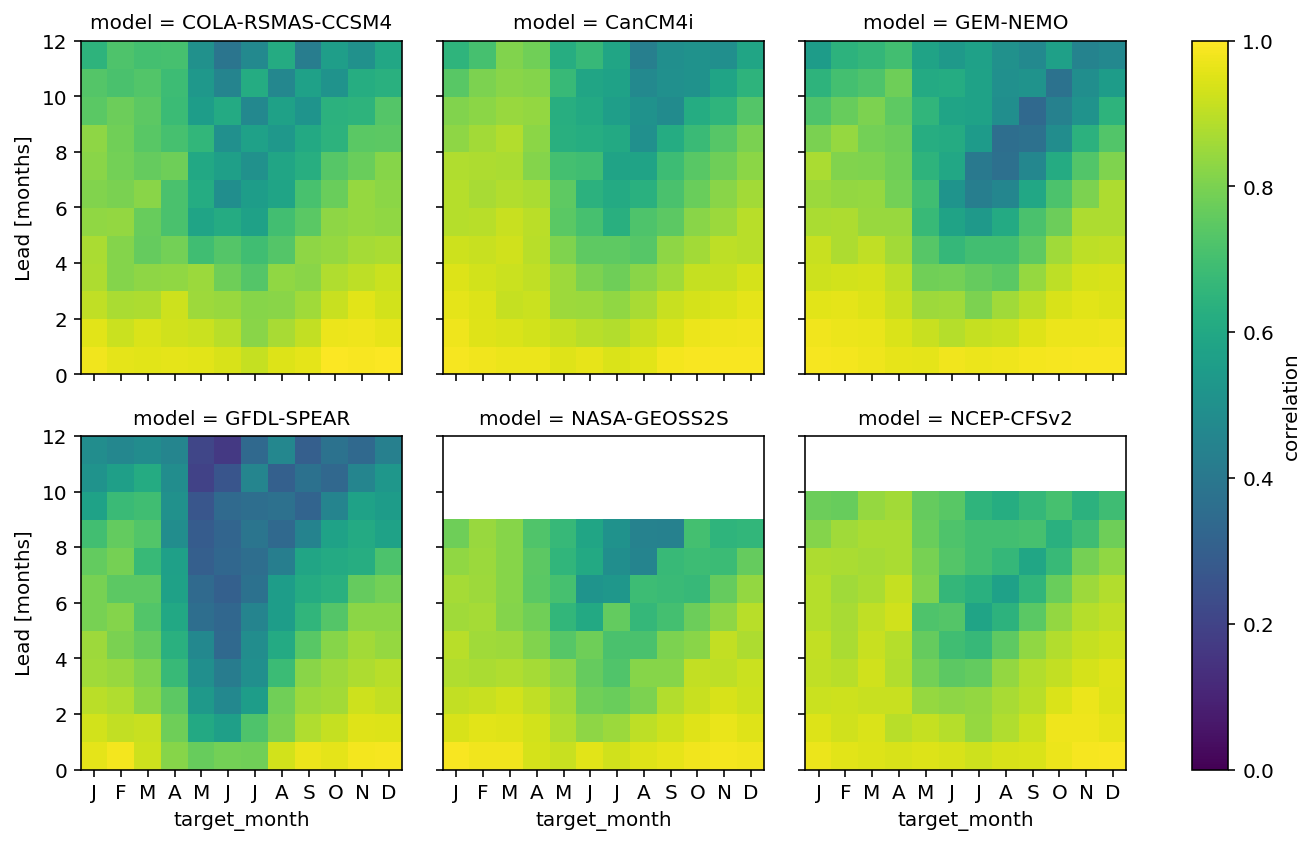

In [32]:
ac_target.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.show()

## 2. MSESS

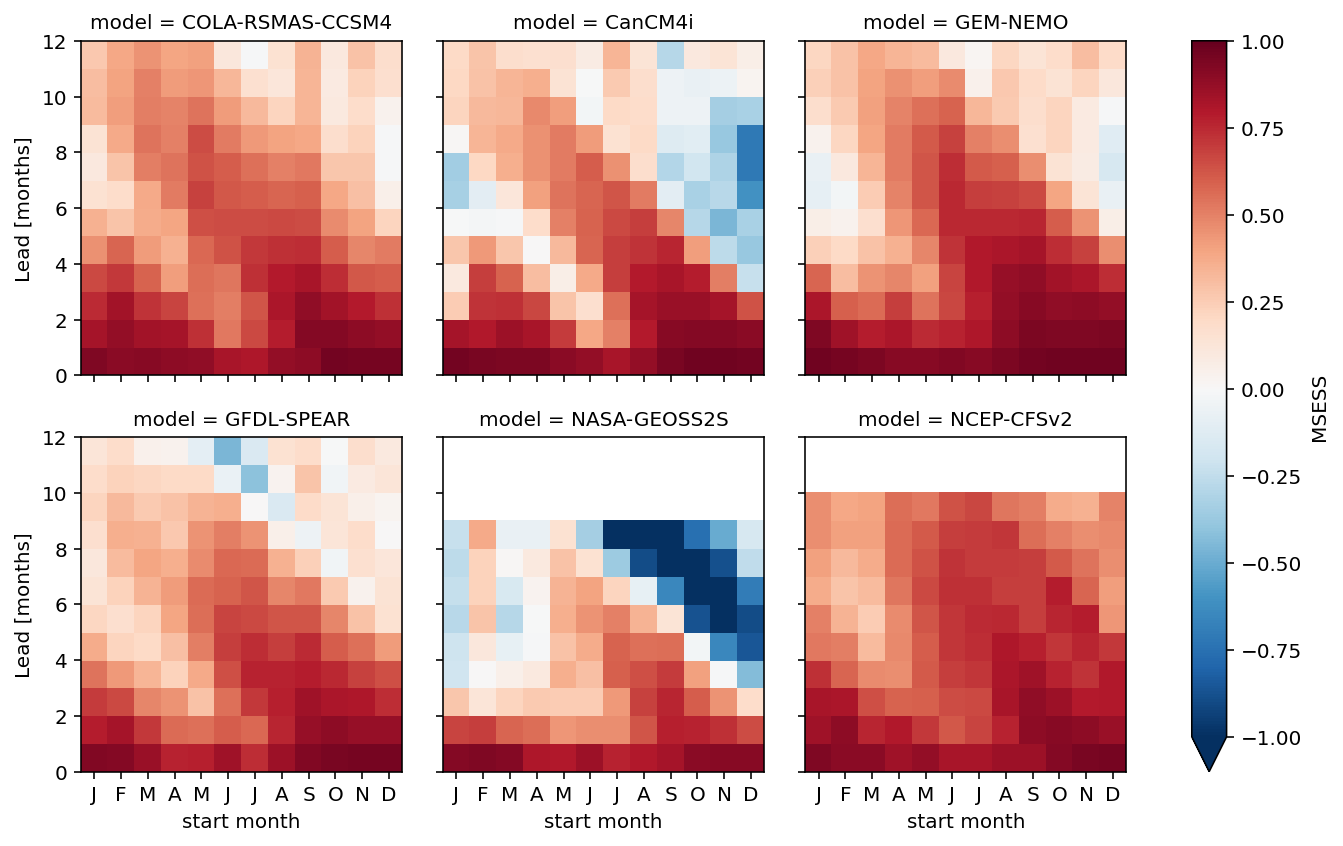

In [33]:
msess = msess_by_start(ds.ssta.mean('M'), ds.obsa)
msess.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.show()

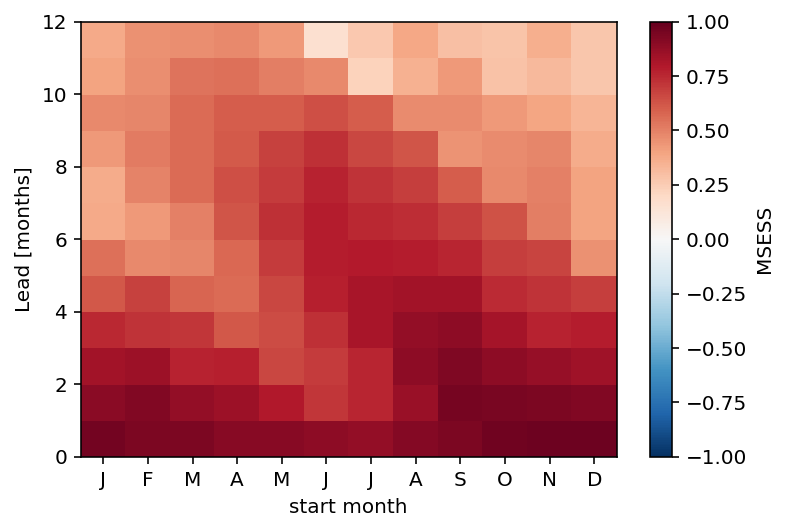

In [34]:
msess_mme = msess_by_start(ds.ssta.mean(('M', 'model')), ds.obsa)
msess_mme.plot(x='month', cmap='RdBu_r', vmin=-1, vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.show()

In [35]:
msess_target = msess.copy()
msess_target.month.attrs['long_name'] = 'target_month'
for ii in range(0, 12):
    msess_target.loc[dict(L=(ii+0.5))] = msess_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

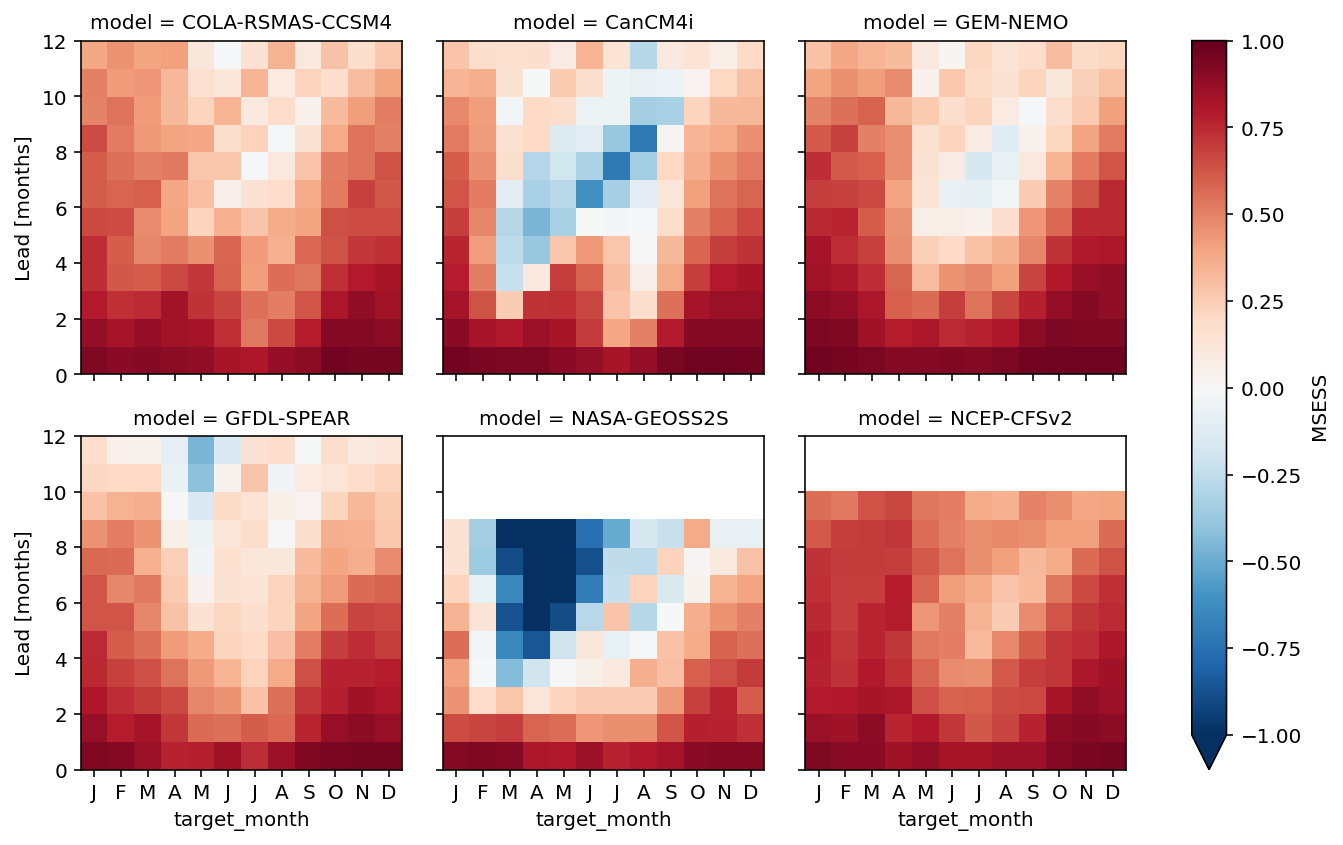

In [36]:
msess_target.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.show()

# Plume

2021-07-01 00:00:00


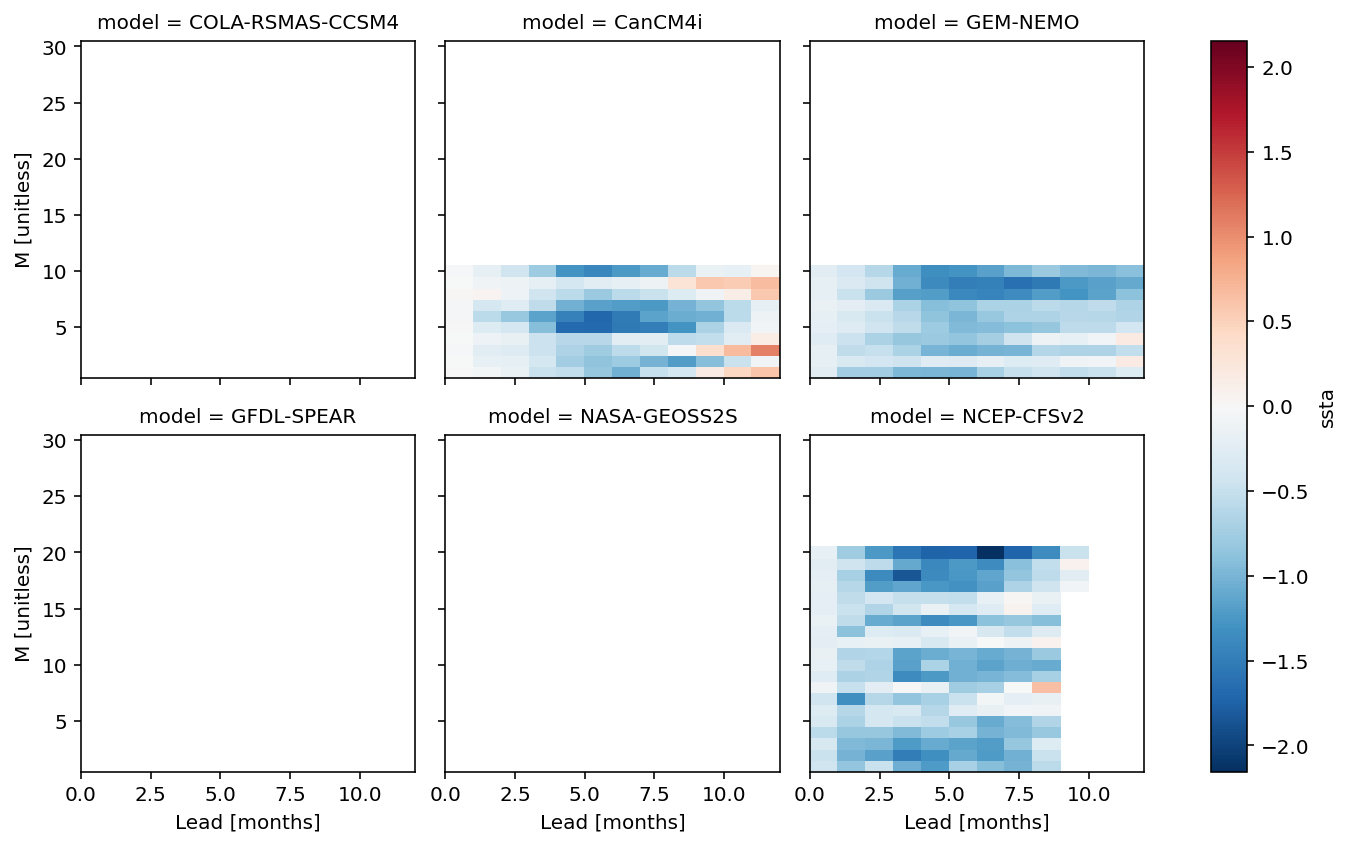

In [37]:
# Most recent forecast
ds.ssta.isel(S=-1).plot(col='model', col_wrap = 3);
print(ds.S[-1].values)

In [38]:
#convert from cftime to regular time
start = ds.indexes['S'].to_datetimeindex()

/Users/tippett/miniconda3/envs/pangeo2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


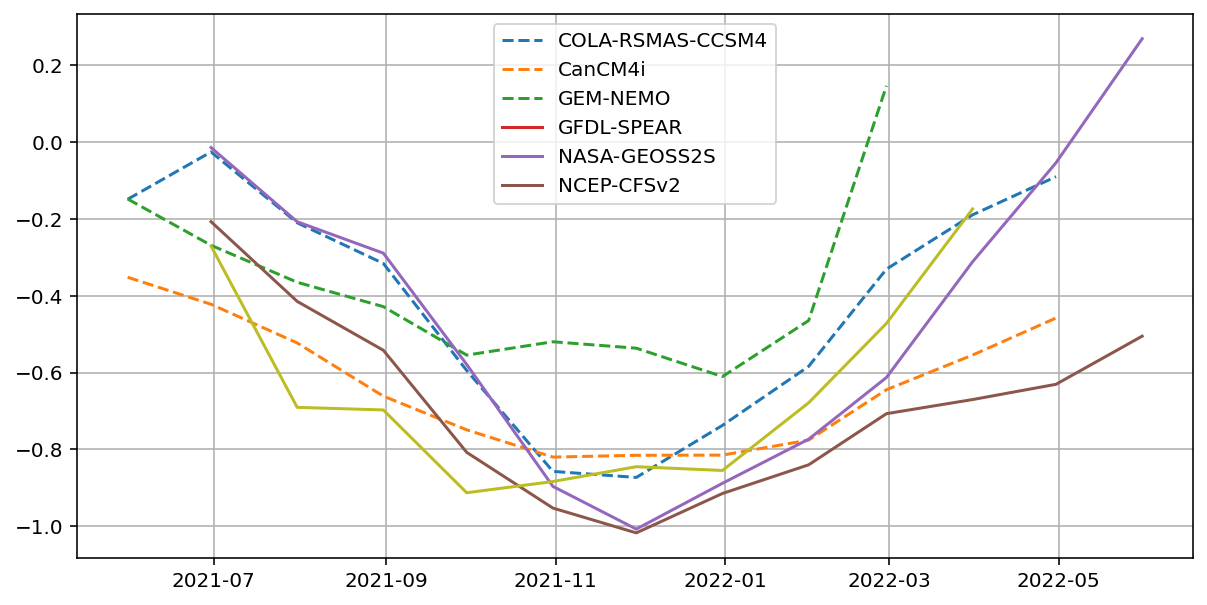

In [58]:
fig,ax = plt.subplots(figsize=(10, 5))
#last month
leads = pd.date_range(start[-3], periods=12, freq="M")
ax.plot(leads, ds.ssta.isel(S=-2).mean('M').T[:, [1, 2, 5]], '--')

#this month
leads = pd.date_range(start[-2], periods=12, freq="M")
ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T)

ax.legend(ds.model.values, ncol=1)
ax.grid()

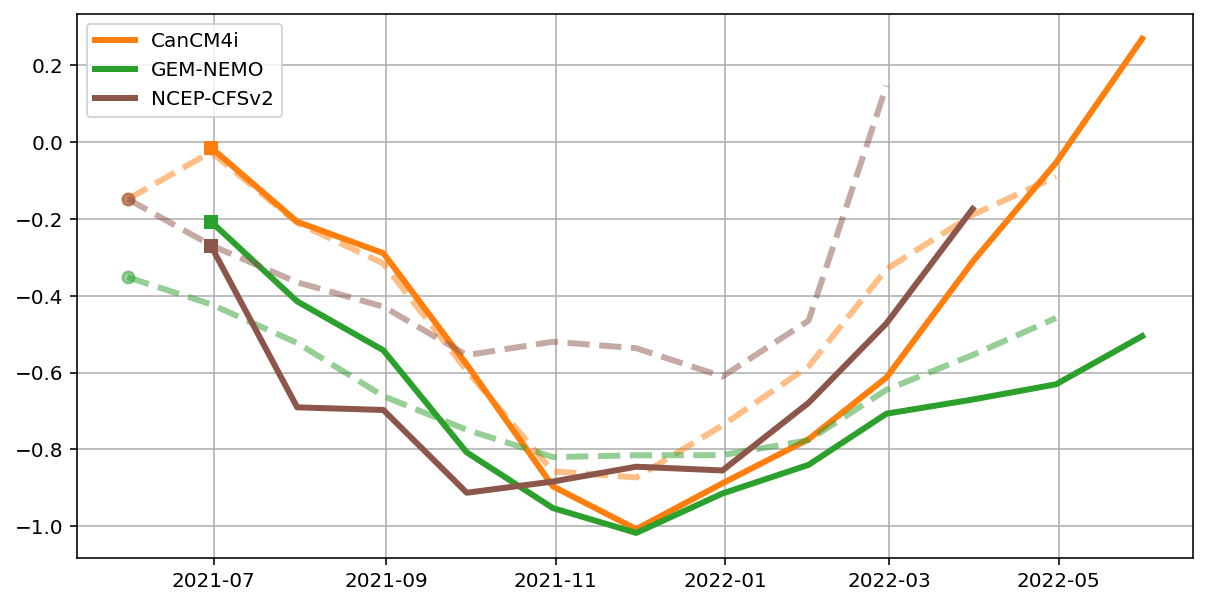

In [94]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))
avail = (1, 2, 5)

fig,ax = plt.subplots(figsize=(10, 5))
for im in avail:
    #last month
    leads = pd.date_range(start[-3], periods=12, freq="M")
    ax.plot(leads, ds.ssta.isel(S=-2).mean('M').T[:, im], '--', lw=3, color=colors[im], alpha=0.5)
    ax.plot(leads[0], ds.ssta.isel(S=-2).mean('M').T[0, im], 'o', lw=3, color=colors[im], alpha=0.5)


    #this month
    leads = pd.date_range(start[-2], periods=12, freq="M")
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=3, color=colors[im], label=ds.model.values[im])
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im])


ax.legend(ncol=1)
ax.grid()
fig.set_facecolor("white")

In [76]:
np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))



(array([1, 2, 5]),)

In [82]:
print(np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M'))))

(array([1, 2, 5]),)
